<center><h1>Developing LLM Applications with LangChain</h1></center>

# 1. Introduction to LangChain & Chatbot Mechanics

# The LangChain ecosystem

**LangChain** comprises of a larger ecosystem that also includes

- **LangSmith** for deploying applications into production

- **LangGraph** for creating AI agents

---
## Prompting OpenAI models

The `ChatOpenAI` class from the `langchain_openai` partner library can be used to define a model to use in LangChain apps. This makes a request to the OpenAI API and returns the response back to the application. OpenAI's API requires an API key, which can also be specified in this class, which will incur some cost for its use. 

In the course, a placeholder API key is provided. 

To prompt this model, we call the `.invoke()` method on a prompt string. 

The `ChatOpenAI` class also accepts parameters `max_completion_tokens`, `temperature`, etc. 

```python
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key='...'
)

llm.invoke("What is LangChain?")
```


---
### Prompting Hugging Face models

If we'd rather work with open-source models downloaded into a local directory, Hugging Face is an excellent choice for finding an appropriate model. 

`HuggingFacePipeline` class and its `.from_model_id()` can be used to download a model for a particular task.

To pass this model a prompt, we again use the `.invoke()` method. 

```python
from langchain_huggingface import HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id(
    model_id="meta-llama/Llama-3.2-3B-Instruct",
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 100}
)

llm.invoke("What is Hugging Face?")
```


---
# Prompt templates

Prompt templates are a fundamental LangChain component that act as reusable recipes for defining prompts for LLMs. 
- Instructions
- Examples
- Additional context 

Prompt templates are created using LangChain's `PromptTemplate` class. 

```python
from langchain_core.prompts import PromptTemplate

template = "Explain this concept simply and concisely: {concept}"
prompt_template = PromptTemplate.from_template(
    template=template
)

prompt = prompt_template.invoke({"concept": "Prompting LLMs"})
print(prompt)
```

**Let's integrate this template with an LLM. We use LangChain's Expression Language (LCEL): `|` (pipe) operator.**
- The pipe operator LCEL creates a chain, which is another fundamental LangChain component. Chains connect a series of calls to different components into a sequence. 
- In this case, the user input will be passed into the prompt template to populate it, then the prompt will be inserted into the LLM. 

```python
llm = HuggingFacePipeline.from_model_id(
    model_id="meta-llama/Llama-3.3-70B-Instruct",
    task="text-generation"
)

llm_chain = prompt_template | llm

concept = "Prompting LLMs"
print(llm_chain.invoke({"concept": concept}))
```

---
## Chat models

**Chat roles:** `system`, `human`, `ai`
- The `system` role is used to define the model behavior

- The `human` role is used for providing user inputs

- The `ai` role is used for defining model responses, which is often used to provide additional examples for the model to learn from

Chat models support prompting with roles, which allow us to specify a series of messages from these roles. 

To create a prompt template including chat message roles, we'll use the `ChatPromptTemplate` class. This allows us to specify a list of tuples containing the roles and messages to pass to the chat model. This list is then passed to the `.from_messages()` method to create the template. 

```python
from langchain_core.prompts import ChatPromptTemplate

template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a calculator that responds with math."),
        ("human", "Answer this math question: What is two plus two?"),
        ("ai", "2+2=4"),
        ("human", "Answer this math question: {math}")
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini", api_key="<OPENAI_AI_TOKEN>")

llm_chain = template | llm
math = "What is five times five?"

response = llm_chain.invoke({"math": math})
print(response.content)
```

---
# Few-shot prompting

So far, we've used `PromptTemplate` and `ChatPromptTemplate` to create reusable templates for different prompt inputs. These classes are great for handling prompts containing a single example, but they don't scale well if we need to integrate many examples from a dataset. 

**The `FewShotPromptTemplate` class allows us to convert datasets like below into prompt templates to provide more context to the model.**

```python
examples = [
    {
        "question": "..."
        "answer": "..."
    },
    ...
]
```

## Building an example set

**Pandas `.to_dict()` can usually be used to directly convert a dataframe to list of dictionaries.**

```python
# Convert pandas DataFrame to list of dicts
examples = df.to_dict(orient="records")

examples = [
    {
        "question": "Does Henry Campbell have any pets?",
        "answer": "Henry Campbell has a dog called Pluto."
    },
    ...
]
```

Before we dive in with creating the few-shot prompt template, we need to decide how we want to structure the examples for the model. 

## Formatting the examples

```python
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate

example_prompt = PromptTemplate.from_template("Question: {question}\n{answer}")

prompt = example_prompt.invoke({"question": "What is the capital of Italy?"
                                "answer": "Rome"})
print(prompt.text)
```

## FewShotPromptTemplate

`FewShotPromptTemplate` takes the examples list of dictionaries we created, and the template for formatting the examples. Additionally, we can provide a `suffix`, which is used to format the user input, and specify what variable the user input will be assigned to. 

```python
prompt_template = FewShotPromptTemplate(
    examples=examples, # the list of dicts
    example_prompt=example_prompt, # formatted template
    suffix="Question: {input}", # suffix to add to the input 
    input_variables=["input"]
)
```

## Invoking the few-shot prompt template

```python 
prompt = prompt_template.invoke({"input": "What is the name of Henry Campbell's dog?"})
print(prompt.text)
```

> Question: Does Henry Campbell have any pets?

> Henry Campbell has a dog called Pluto.

> ...

> Question: What is the name of Henry Campbell's dog?

## Integration with a chain

```python
llm = ChatOpenAI(model="gpt-4o-mini", api_key="...")

llm_chain = prompt_template | llm
response = llm_chain.invoke({"input": "What is the name of Henry Campbell's dog?"})
print(response.content)
```

> The name of Henry Campbell's dog is Pluto. 

---
# 2. Chains and Agents

# Sequential chains

Some problems can only be solved sequentially. In sequential chains, the output from one chain becomes the input to another. 

We will create two prompt templates: one to generate suggestions for activities from the input destination, and another to create an itinerary for one day of activities from the model's top three suggestions. 

Define the squential chain: we start by defining a `dictionary` that passes our destination prompt template to the LLM and parses the output to a string, all using LCEL's pipe. This gets assigned to the `activities` key, which is important, as this is the input variable to the second prompt template. We pipe the first chain into the second prompt template, then into the LLM, and again, parse to a string.  

To summarize: the `destination_prompt` is passed to the LLM to generate the activity suggestions, and the output is parsed to a string and assigned to `activities`. This is passed to the second activities_prompt, which is passed to the llm to generate the itinerary, which is parsed as a string. 


```python
destination_prompt = PromptTemplate(
    input_variables=["destination"],
    template="I am planning a trip to {destination}. Can you suggest some activities to do there?"
)
activities_prompt = PromptTemplate(
    input_variables=["activities"],
    template="I only have one day, so can you create an itinerary from your top three activities: {activities}."
)

llm = ChatOpenAI(model="gpt-4o-mini", api_key=openai_api_key)

seq_chain = ({"activities": destination_prompt | llm | StrOutputParser()}
    | activities_prompt
    | llm
    | StrOutputParser())

print(seq_chain.invoke({"destination": "Rome"}))
```

---
# Introduction to LangChain agents

**Agents:** In LangChain, agents use language models to determine actions. 

**Tools:** Agents often use `tools`, which are `functions` called by the agent to interact with the system. These tools can be high-level utilities to transform inputs, or they can be task-specific. Agents can even use chains and other agents as tools! 

## ReAct agents

ReAct = Reasoning + Acting 
- It prompts the model using a repeated loop of thinking, acting, and observing. If we were to ask a ReAct agent that had access to a weather tool, "What is the weather like in Kingston, Jamaica?", it would start by thinking about the task and which tool to call, call that tool using the information, and observe the results from the tool call. 

**To implement agents, we use `LangGraph`, which is a branch of the LangChain ecosystem specifically for designing agentic systems, or systems including agents.** Like LangChain's core library, it is built to provide a unified, tool-agnostic syntax. 

Version used in this course: `pip install langgraph==0.2.74`

---

We will create a ReAct agent that solves math problems. 

```python
from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits.load_tools import load_tools

llm = ChatOpenAI(model="gpt-4o-mini", api_key=openai_api_key)
tools = load_tools(["llm-math"], llm=llm)
agent = create_react_agent(llm, tools)

messages = agent.invoke({"messages:" [("human", "What is the square root of 101?")]})
print(messages) 
print(messages['messages'][-1].content)
```

---
# Custom tools for agents


## Tool formats

Tools in LangChain must be formatted in a specific way to be compatible with agents. 
- They must have a name, accessible via the `.name` attribute. 
- A `description`, which is used by the LLM to determine when to call the tool. 
- The `return_direct` parameter indicates whether the agent should stop after invoking this tool. Set to `False` by default.

**Understanding this required format will help us to understand how to create our own tools.**

```python
from langchain_community.agent_toolits.load_tools import load_tools

tools = load_tools(["llm-math"], llm=llm)
print(tools[0].name) # Calculator
print(tools[0].description) # Useful for when you need to answer questions about math.
print(tools[0].return_direct) # False
```

## Defining a custom function

Let's say we want to define a Python function to generate a financial report for a company. 

```python
def financial_report(company_name: str, revenue: int, expenses: int) -> str:
    """Generate a financial report for a company that calculates net income."""
    net_income = revenue - expenses
    
    report = f"Financial Report for {company_name}:\n"
    report += f"Revenue: ${revenue}\n"
    report += f"Expenses: ${expenses}\n"
    report += f"Net Income: ${net_income}\n"
    
    return report
    
print(financial_report(company_name="LemonadeStand", revenue=100, expenses=50))
# Financial Report for LemonadeStand:
# Revenue: $100
# Expenses: $50
# Net Income: $50
```

## From functions to tools

Let's convert this function into a tool our agent can call. 

To do this, we import the `@tool` decorator and add it before the function definition. 

```python
from langchain_core.tools import tool

@tool
def financial_report(company_name: str, revenue: int, expenses: int) -> str:
    """Generate a financial report for a company that calculates net income."""
    net_income = revenue - expenses
    
    report = f"Financial Report for {company_name}:\n"
    report += f"Revenue: ${revenue}\n"
    report += f"Expenses: ${expenses}\n"
    report += f"Net Income: ${net_income}\n"
    
    return report
```

## Examine our new tool

```python
print(financial_report.name)
print(financial_report.description)
print(financial_report.return_direct)
print(financial_report.args)
```

## Integrating the custom tool

```python
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini", api_key=openai_api_key, temperature=0)
agent = create_react_agent(llm, [financial_report])

messages = agent.invoke({"messages": [("human", "TechStack generated made $10 million dollars with $8 million of costs. Generate a financial report.")]})
print(messages)
```

---
# 3. Retrieval Augmented Generation (RAG)

# Integrating document loaders

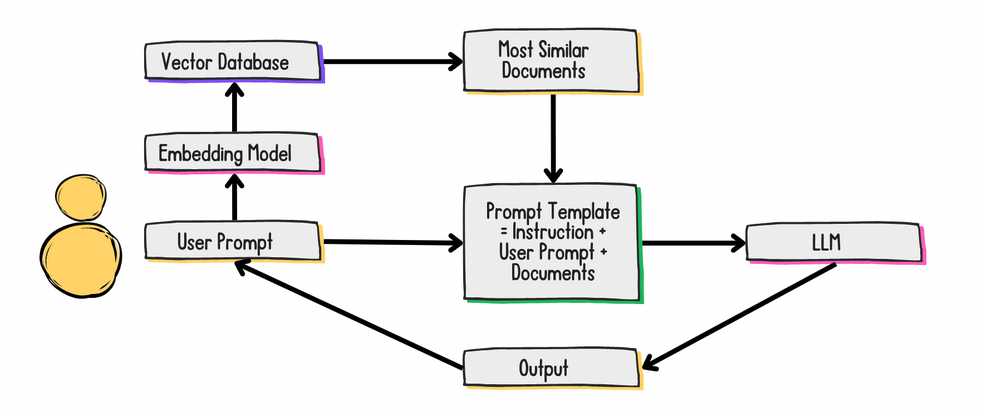

**RAG:** use **embeddings** to retrieve relevant information to integrate into the prompt 

Pre-trained language models don't have access to external data sources, their understanding comes purely from their training data. In RAG, a user query is embedded and used to retrieve the most relevant documents from the database. Then, these documents are added to the model's prompt so that the model has extra context to inform its response.

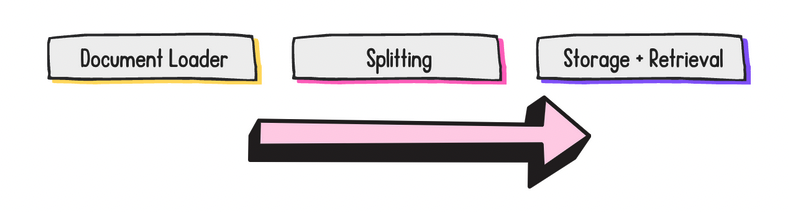

**Three primary steps to RAG development in LangChain.**
- Document Loader
- Splitting: chunks are units of information that we can indx and process individually
- Storage + Retrieval: could utilize a vector database if that meets the needs of the use case

## LangChain document loaders

Classes designed to `load` and `configure` documents for system integraion

LangChain provides document loader classes for common file types such as `.csv` and `.pdf`

There are also 3rd party loaders for managing unique document: Amazon S3 files, `.ipynb`, `.wav`

## PDF document loader 

There are several PDF document loader options provided by LangChain. Here, we use `PyPDFLoader`

```python
# Requires installation of the pypdf package: pip install pypdf
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("path/to/file/attention_is_all_you_need.pdf")
data = loader.load() 
print(data[0])
```

## CSV document loader

```python
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader("fifa_countries_audience.csv")

data = loader.load()
print(data[0])
```

## HTML document loader

```python
# Require the unstructured package: pip install unstructured
from langchain_community.document_loaders import UnstructuredHTMLLoader

loader = UnstructuredHTMLLoader("white_house_executive_order_nov_2023.html")
data = loader.load()
print(data[0])
print(data[0].metadata)
```

---
# Splitting external data for retrieval

`Chunking` is particularly useful for breaking up long documents so that they fit within an LLM's context window. 

## Chunk overlap

To counteract lost context during chunk splitting, a chunk overlap is often implemented. Having the extra overlap present in both chunks helps retain context.

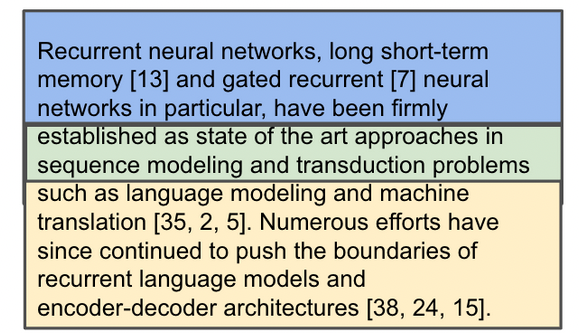

If a model shows signs of losing context and misunderstanding information when answering from external sources, we may need to increase the chunk overlap. 

There isn't one document splitting strategy that works for all situations. We should experiment with multiple methods, and see which one strikes the right balance between retaining context and managing chunk size. 

```python
quote = '''One machine can do the work of fifty ordinary humans.\nNo machine can do the work of one extraordinary human.'''
len(quote) #103
chunk_size = 24
chunk_overlap = 3
```

**`CharacterTextSplitter`** splits on the separator in an attempt to make chunks smaller than chunk_size, but may not always succeed!

```python
from langchain_text_splitters import CharacterTextSplitter

ct_splitter = CharacterTextSplitter(
    separator='.',
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap)

docs = ct_splitter.split_text(quote)
print(docs)
print([len(doc) for doc in docs]) # In this case, each doc actually has more characters than the specified chunk_size
```

**`RecursiveCharacterSplitter`** takes a list of separators to split on, and it works through the list from left to right, splitting the document using each separator in turn, and seeing if these chunks can be combined while remaining under `chunk_size`. 

```python
from langchain_text_splitters import RecursiveCharacterTextSplitter

rc_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap)

docs = rc_splitter.split_text(quote)
print(docs)
# ['One machine can do the',
#  'work of fifty ordinary',
#  'human.',
#  'No machine can do the',
#  'work of one',
#  'extraordinary human.']
```

**We can also split other formats, like HTML**

```python
from langchain_community.document_loaders import UnstructuredHTMLLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = UnstructuredHTMLLoader("white_house_executive_order_nov_2023.html")
data = loader.load()

rc_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=['.'])

docs = rc_splitter.split_documents(data)
print(docs[0])
```

---
# RAG storage and retrieval using vector databases

We'll be using a vector database to store our documents and make them available for retrieval. This requires `embedding` our text documents to create vectors that capture the semantic meaning of the text. Then, a user query can be embedded to retrieve the most similar documents from the database and insert them into the model prompt. 

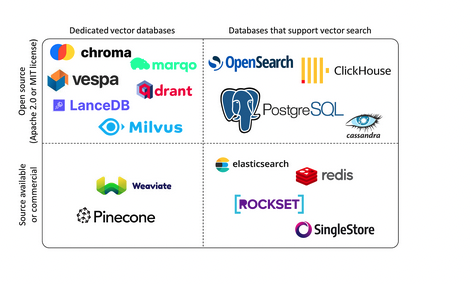

**Which vector database should I use? Consider:**
- Open source vs. closed source (license)
- Cloud vs. on-premises
- Lightweight vs. powerful

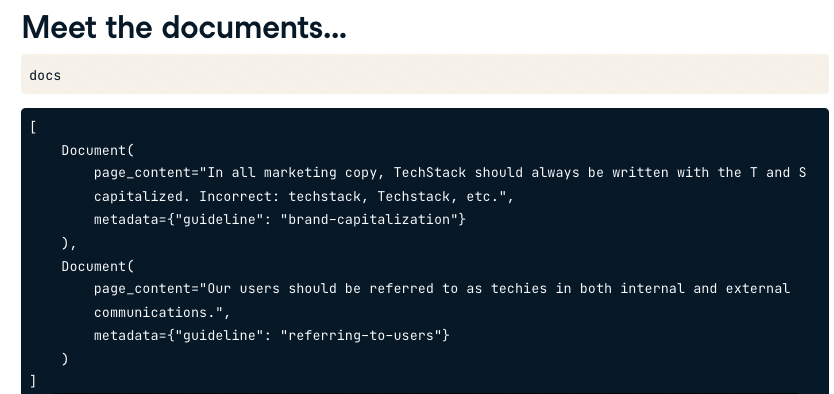

## Setting up a Chroma vector database

```python
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

embedding_function = OpenAIEmbeddings(api_key=openai_api_key, model='text-embedding-3-small')

vectorstore = Chroma.from_documents(
    docs,
    embedding=embedding_function,
    persist_directory="path/to/directory"
)

retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 2}
)
```

## Building a prompt template

```python
from langchain_core.prompts import ChatPromptTemplate

message = """
Review and fix the following TechStack marketing copy with the following guidelines in consideration:

Guidelines:
{guidelines}

Copy:
{copy}

Fixed Copy:
"""

prompt_template = ChatPromptTemplate.from_messages([("human", message)])
```

## Chaining it all together 

```python
from langchain_core.runnables import RunnablePassthrough

rag_chain = ({"guidelines": retriever, "copy": RunnablePassthrough()}
            | prompt_template
            | llm)

response = rag_chain.invoke("Here at techstack, our users are the best in the world!")
print(response.content)
```